# Import lib

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# baca data

In [ ]:
transactions = pd.read_csv('/content/drive/MyDrive/dataset/final-project-SC/transactions_des21_july22.csv', on_bad_lines='skip') 
customer = pd.read_csv('/content/drive/MyDrive/dataset/final-project-SC/customer.csv', on_bad_lines='skip')
product = pd.read_csv('/content/drive/MyDrive/dataset/final-project-SC/product.csv', on_bad_lines='skip')
click_stream = pd.read_csv('/content/drive/MyDrive/dataset/final-project-SC/click_streams_des21_july22.csv', on_bad_lines='skip')

In [ ]:
df = [click_stream, customer, product, transactions]

for i in df:
  print(i.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3352819 entries, 0 to 3352818
Data columns (total 6 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   session_id      object
 1   event_name      object
 2   event_time      object
 3   event_id        object
 4   traffic_source  object
 5   event_metadata  object
dtypes: object(6)
memory usage: 153.5+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   customer_id         100000 non-null  int64  
 1   first_name          100000 non-null  object 
 2   last_name           100000 non-null  object 
 3   username            100000 non-null  object 
 4   email               100000 non-null  object 
 5   gender              100000 non-null  object 
 6   birthdate           100000 non-null  object 
 7   device_type         100000 non-null  object 
 8   de

In [ ]:
click_stream['event_time'] = pd.to_datetime(click_stream['event_time'])
customer['birthdate'] = pd.to_datetime(customer['birthdate'], format="%Y/%m/%d %H:%M:%S")
customer['first_join_date'] = pd.to_datetime(customer['first_join_date'], format="%Y/%m/%d %H:%M:%S")
transactions['created_at'] = pd.to_datetime(transactions['created_at'], format="%Y/%m/%d %H:%M:%S")

In [ ]:
transactions['hasil_metadata'] = transactions['product_metadata'].apply(lambda x : x.split())


transactions['product_id'] = transactions['hasil_metadata'].str[1]
transactions['product_quantity'] = transactions['hasil_metadata'].str[3]
transactions['product_price'] = transactions['hasil_metadata'].str[5]


transactions['product_id'] = transactions['product_id'].apply(lambda x: x.replace(',',''))
transactions['product_quantity'] = transactions['product_quantity'].apply(lambda x: x.replace(',',''))
transactions['product_price'] = transactions['product_price'].apply(lambda x: x.replace('}]',''))
transactions['product_price'] = transactions['product_price'].apply(lambda x: x.replace('},','')) 

transactions = transactions.drop(columns=['hasil_metadata'])

transactions['product_quantity'] = transactions['product_quantity'].astype('int64')
transactions['product_price'] = transactions['product_price'].astype('int64')
transactions['product_id'] = transactions['product_id'].astype('int64')
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 219127 entries, 0 to 219126
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype              
---  ------                  --------------   -----              
 0   created_at              219127 non-null  datetime64[ns, UTC]
 1   customer_id             219127 non-null  int64              
 2   booking_id              219127 non-null  object             
 3   session_id              219127 non-null  object             
 4   product_metadata        219127 non-null  object             
 5   payment_method          219127 non-null  object             
 6   payment_status          219127 non-null  object             
 7   promo_amount            219127 non-null  int64              
 8   promo_code              70599 non-null   object             
 9   shipment_fee            219127 non-null  int64              
 10  shipment_date_limit     219127 non-null  object             
 11  shipment_location_lat   21

In [ ]:
trx_cust = pd.merge(customer, transactions, on='customer_id')
trx_cust = pd.merge(trx_cust, product, left_on='product_id', right_on='id')
trx_cust = pd.merge(trx_cust, click_stream, on='session_id')

trx_cust = trx_cust.rename(columns={'created_at':'trx_created_at','gender_x':'gender_cust','gender_y':'gender_prod'})

trx_cust.info()

trx_cust.isna().sum()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 3278129 entries, 0 to 3278128
Data columns (total 46 columns):
 #   Column                  Dtype              
---  ------                  -----              
 0   customer_id             int64              
 1   first_name              object             
 2   last_name               object             
 3   username                object             
 4   email                   object             
 5   gender_cust             object             
 6   birthdate               datetime64[ns]     
 7   device_type             object             
 8   device_id               object             
 9   device_version          object             
 10  home_location_lat       float64            
 11  home_location_long      float64            
 12  home_location           object             
 13  home_country            object             
 14  first_join_date         datetime64[ns]     
 15  trx_created_at          datetime64[ns, UTC]
 16  

customer_id                     0
first_name                      0
last_name                       0
username                        0
email                           0
gender_cust                     0
birthdate                       0
device_type                     0
device_id                       0
device_version                  0
home_location_lat               0
home_location_long              0
home_location                   0
home_country                    0
first_join_date                 0
trx_created_at                  0
booking_id                      0
session_id                      0
product_metadata                0
payment_method                  0
payment_status                  0
promo_amount                    0
promo_code                2093196
shipment_fee                    0
shipment_date_limit             0
shipment_location_lat           0
shipment_location_long          0
total_amount                    0
product_id                      0
product_quanti

# menentukan time Window
Time Window : 6 Bulan

calibration period : Desember 2021 - Mei 2022
untuk label Juni 2022

holdou period : Januari 2022- Juni 2022 untuk label Juli 2022

churn : seseorang yg tidak berbelanja di bulan tertentu

In [ ]:
calib_data = trx_cust[(trx_cust['trx_created_at'] >='2021-12-01')&(trx_cust['trx_created_at'] <='2022-05-31')]
calib_data

,customer_id,first_name,last_name,username,email,gender_cust,birthdate,device_type,device_id,device_version,...,baseColour,season,year,usage,productDisplayName,event_name,event_time,event_id,traffic_source,event_metadata
0,7279,Bakiman,Simanjuntak,3250e5a3-1d23-4675-a647-3281879d42be,3250e5a3_1d23_4675_a647_3281879d42be@startupca...,M,1989-01-23,iOS,d13dde0a-6ae1-43c3-83a7-11bbb922730b,iPad; CPU iPad OS 4_2_1 like Mac OS X,...,Blue,Summer,2012.0,Casual,Madagascar3 Boys Blue Printed T-Shirt,BOOKING,2021-12-01 00:11:37.916342+00:00,c4f4db01-3bcd-4d6e-9217-eb8046107d1d,MOBILE,{'payment_status': 'Success'}
35,13727,Zulaikha,Usada,5c0a8583-9866-4de5-9128-34d63c12d949,5c0a8583_9866_4de5_9128_34d63c12d949@startupca...,F,2001-08-23,iOS,ad7e6395-6351-41ec-9e5f-3790b6714a57,iPad; CPU iPad OS 3_1_3 like Mac OS X,...,Blue,Summer,2012.0,Casual,Madagascar3 Boys Blue Printed T-Shirt,HOMEPAGE,2022-03-03 12:46:29.394928+00:00,d5e9221c-0d39-4685-8f61-b5d4e4e1cd18,MOBILE,NaN
36,13727,Zulaikha,Usada,5c0a8583-9866-4de5-9128-34d63c12d949,5c0a8583_9866_4de5_9128_34d63c12d949@startupca...,F,2001-08-23,iOS,ad7e6395-6351-41ec-9e5f-3790b6714a57,iPad; CPU iPad OS 3_1_3 like Mac OS X,...,Blue,Summer,2012.0,Casual,Madagascar3 Boys Blue Printed T-Shirt,ADD_TO_CART,2022-03-07 15:18:06.394928+00:00,8c3358d3-9505-46e5-b2df-acfc9b2af1f1,MOBILE,"{'product_id': 37598, 'quantity': 1, 'item_pri..."
37,13727,Zulaikha,Usada,5c0a8583-9866-4de5-9128-34d63c12d949,5c0a8583_9866_4de5_9128_34d63c12d949@startupca...,F,2001-08-23,iOS,ad7e6395-6351-41ec-9e5f-3790b6714a57,iPad; CPU iPad OS 3_1_3 like Mac OS X,...,Blue,Summer,2012.0,Casual,Madagascar3 Boys Blue Printed T-Shirt,ADD_PROMO,2022-03-11 18:01:12.394928+00:00,7e626026-2ac8-4692-bee2-8534499fda98,MOBILE,"{'promo_code': 'WEEKENDSERU', 'promo_amount': ..."
38,13727,Zulaikha,Usada,5c0a8583-9866-4de5-9128-34d63c12d949,5c0a8583_9866_4de5_9128_34d63c12d949@startupca...,F,2001-08-23,iOS,ad7e6395-6351-41ec-9e5f-3790b6714a57,iPad; CPU iPad OS 3_1_3 like Mac OS X,...,Blue,Summer,2012.0,Casual,Madagascar3 Boys Blue Printed T-Shirt,BOOKING,2022-03-19 22:42:57.394928+00:00,26a6a28c-aa99-45f2-9c2a-965050ac7590,MOBILE,{'payment_status': 'Success'}
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3278124,58370,Umi,Melani,faae7fda-b9ea-4129-8183-87206bbeeed7,faae7fda_b9ea_4129_8183_87206bbeeed7@startupca...,F,1999-01-26,Android,00d9e037-d019-4c4e-97b4-ed7d2c798b64,Android 4.0,...,White,Fall,2011.0,Sports,ADIDAS Men Galaxy Elite M White Sports Shoes,CLICK,2022-01-24 14:42:06.018171+00:00,d5b9799a-28c2-4b08-82f3-4616d9eda26f,MOBILE,NaN
3278125,58370,Umi,Melani,faae7fda-b9ea-4129-8183-87206bbeeed7,faae7fda_b9ea_4129_8183_87206bbeeed7@startupca...,F,1999-01-26,Android,00d9e037-d019-4c4e-97b4-ed7d2c798b64,Android 4.0,...,White,Fall,2011.0,Sports,ADIDAS Men Galaxy Elite M White Sports Shoes,ADD_TO_CART,2022-01-24 14:57:39.018171+00:00,8fac4e25-01ce-46ef-b75a-c22bdf132d20,MOBILE,"{'product_id': 59046, 'quantity': 1, 'item_pri..."
3278126,58370,Umi,Melani,faae7fda-b9ea-4129-8183-87206bbeeed7,faae7fda_b9ea_4129_8183_87206bbeeed7@startupca...,F,1999-01-26,Android,00d9e037-d019-4c4e-97b4-ed7d2c798b64,Android 4.0,...,White,Fall,2011.0,Sports,ADIDAS Men Galaxy Elite M White Sports Shoes,SCROLL,2022-01-24 15:13:30.018171+00:00,1f883884-5e01-4213-9f42-0da905358aea,MOBILE,NaN
3278127,58370,Umi,Melani,faae7fda-b9ea-4129-8183-87206bbeeed7,faae7fda_b9ea_4129_8183_87206bbeeed7@startupca...,F,1999-01-26,Android,00d9e037-d019-4c4e-97b4-ed7d2c798b64,Android 4.0,...,White,Fall,2011.0,Sports,ADIDAS Men Galaxy Elite M White Sports Shoes,ITEM_DETAIL,2022-01-24 15:29:27.018171+00:00,bc92f2a5-9157-448f-a906-dd27231d978c,MOBILE,NaN


# Mencari Attributes

## umur akun pengguna

In [ ]:
##umur pengguna
now = pd.to_datetime('2022-05-31')

cust_age = calib_data.groupby('customer_id')['first_join_date'].max().reset_index()
cust_age['customer_days'] = (now - cust_age['first_join_date']).astype('timedelta64[D]')
cust_age = cust_age.drop(columns=['first_join_date'])
cust_age

,customer_id,customer_days
0,3,1375.0
1,8,472.0
2,9,339.0
3,11,86.0
4,15,976.0
...,...,...
32344,99989,422.0
32345,99991,465.0
32346,99992,700.0
32347,99995,653.0


## jumlah promo 
yg digunakan oleh tiap customer

In [ ]:
calib_data['promo_code'] = calib_data['promo_code'].fillna('no promo')
calib_data['use_promo'] = calib_data['promo_code'].apply(lambda x: 1 if (x != 'no promo')  else 0)
num_promo = calib_data.groupby('customer_id')['use_promo'].sum().reset_index()
num_promo = num_promo.rename(columns={'use_promo':'number_used_promo'})

<ipython-input-10-5f1508d40183>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calib_data['promo_code'] = calib_data['promo_code'].fillna('no promo')
<ipython-input-10-5f1508d40183>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  calib_data['use_promo'] = calib_data['promo_code'].apply(lambda x: 1 if (x != 'no promo')  else 0)


## jumlah transaksi


In [ ]:
clb_trx_success = calib_data[calib_data['payment_status']== 'Success']

frequency = clb_trx_success.groupby('customer_id')['booking_id'].count().reset_index()
frequency = frequency.rename(columns={'booking_id':'number_order'})
frequency

,customer_id,number_order
0,3,95
1,8,12
2,9,14
3,11,14
4,15,12
...,...,...
31956,99988,82
31957,99989,5
31958,99992,16
31959,99995,227


## total profit
adalah jumlah uang yang dikeluarkan oleh tiap-tiap customer

In [ ]:
profit = clb_trx_success.groupby('customer_id')['total_amount'].sum().reset_index()
profit

,customer_id,total_amount
0,3,31879690
1,8,8780977
2,9,4185925
3,11,2765462
4,15,879840
...,...,...
31956,99988,34409802
31957,99989,1643406
31958,99992,2521342
31959,99995,74590049


## ratio pembelian success denga pembelian gagal

In [ ]:
ratio_trx = (pd.crosstab(calib_data['customer_id'], calib_data['payment_status'], normalize='index')
         .mul(1)
         .reset_index()
         .rename_axis(None, axis=1))
ratio_trx = ratio_trx.drop(columns=['Failed']).rename(columns={'Success':'ratio'})
ratio_trx


,customer_id,ratio
0,3,1.0
1,8,1.0
2,9,1.0
3,11,1.0
4,15,1.0
...,...,...
32344,99989,1.0
32345,99991,0.0
32346,99992,1.0
32347,99995,1.0


## delta pertama dan terakhir beli
selisih antara hari pertama beli dengan hari terakhir beli

In [ ]:
delta_last_first = clb_trx_success.groupby('customer_id').agg(
    date_min=('trx_created_at', 'min'),
    date_max=('trx_created_at', 'max')
).reset_index()
delta_last_first['first_to_last_buy_days'] = (delta_last_first['date_max'] - delta_last_first['date_min']).dt.days
delta_last_first = delta_last_first.drop(columns={'date_min','date_max'})
delta_last_first['first_to_last_buy_days'].value_counts()


0      8641
168    1140
160     885
144     652
156     609
       ... 
5         1
8         1
178       1
17        1
4         1
Name: first_to_last_buy_days, Length: 176, dtype: int64

## ratio booking dengan aktivitas lainnya

In [ ]:
ratio_session = (pd.crosstab(calib_data['customer_id'], calib_data['event_name'], normalize='index')
         .mul(1)
         .reset_index()
         .rename_axis(None, axis=1))

ratio_session
ratio_booking = ratio_session[['customer_id','BOOKING']]
ratio_booking

,customer_id,BOOKING
0,3,0.073684
1,8,0.250000
2,9,0.214286
3,11,0.071429
4,15,0.083333
...,...,...
32344,99989,0.400000
32345,99991,0.500000
32346,99992,0.187500
32347,99995,0.066079


## selisih hari terakhir transaski dengan hari ini

In [ ]:
now = pd.to_datetime('2022-05-31')

day = (clb_trx_success.groupby('customer_id')['trx_created_at']
       .max().reset_index())
day['last_day'] = ((now - day['trx_created_at']
                    .dt.tz_localize(None)).dt.days)
day = day.drop(columns={'trx_created_at'})
day

,customer_id,last_day
0,3,1
1,8,15
2,9,2
3,11,84
4,15,145
...,...,...
31956,99988,5
31957,99989,57
31958,99992,5
31959,99995,0


## rata-rata product per order 
rata-rata product per order tiap customer

In [ ]:
avg_order_value = (calib_data.groupby('customer_id')['product_price']
                .mean().reset_index())
avg_order_value = (pd.DataFrame(data = avg_order_value)
                .rename(columns = {'product_price' : 'avg_value_per_order'}))
avg_order_value

,customer_id,avg_value_per_order
0,3,236161.568421
1,8,247403.083333
2,9,246166.071429
3,11,192025.000000
4,15,67200.000000
...,...,...
32344,99989,186922.600000
32345,99991,138328.000000
32346,99992,150708.875000
32347,99995,243020.528634


## cara pembayaran
jenis pembayaran yg sering dipakai

In [ ]:
#Membuat tabel metode pembayaran yang paling banyak digunakan customer
top_payment_method = (calib_data.groupby(['customer_id'])['payment_method']
                      .max(trx_cust['payment_method'].value_counts().argmax())
                      .reset_index())
top_payment_method = (pd.DataFrame(data = top_payment_method)
                      .rename(columns = {
                          'payment_method':'preferred_payment_method'})
                      .sort_values(by = 'preferred_payment_method', 
                                   ascending = False))
top_payment_method['preferred_payment_method'].value_counts()

OVO            11240
Credit Card     6455
Gopay           6035
LinkAja         4689
Debit Card      3930
Name: preferred_payment_method, dtype: int64

## alamat pengguna

In [ ]:
address_cust = customer[['customer_id','home_location']]
address_cust

,customer_id,home_location
0,2870,Sumatera Barat
1,8193,Jakarta Raya
2,7279,Nusa Tenggara Barat
3,88813,Kalimantan Timur
4,82542,Kalimantan Selatan
...,...,...
99995,34743,Lampung
99996,72065,Aceh
99997,32818,Maluku
99998,75597,Jambi


## device pengguna

In [ ]:
device_cust = customer[['customer_id','device_type']]
device_cust

,customer_id,device_type
0,2870,iOS
1,8193,Android
2,7279,iOS
3,88813,iOS
4,82542,iOS
...,...,...
99995,34743,Android
99996,72065,Android
99997,32818,Android
99998,75597,Android


## bulan terakhir transaksi : Label
bulan terakhir transaksi untuk label churn

In [ ]:
label = trx_cust[
    (trx_cust['trx_created_at']>='2021-12-01') & 
    (trx_cust['trx_created_at']<='2022-06-30')]

last_trx_month = (label.groupby('customer_id')['trx_created_at']
                  .max().reset_index())
last_trx_month['last_trx_month'] = (last_trx_month['trx_created_at']
                                    .dt.to_period('M'))
last_trx_month['churn'] = np.where(
    last_trx_month['last_trx_month']=='2022-06','no','yes')
last_trx_month = last_trx_month.drop(
    columns={'trx_created_at','last_trx_month'})
last_trx_month

/usr/local/lib/python3.8/dist-packages/pandas/core/arrays/datetimes.py:1143: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  warnings.warn(


,customer_id,churn
0,3,no
1,8,yes
2,9,yes
3,11,yes
4,15,yes
...,...,...
33121,99989,yes
33122,99991,yes
33123,99992,yes
33124,99995,no


## merge attribut

In [ ]:
calib_df = pd.merge(cust_age,frequency, on='customer_id', how='left')
calib_df = calib_df.merge(profit, on='customer_id', how='left')
calib_df = calib_df.merge(num_promo, on='customer_id', how='left')
calib_df = calib_df.merge(ratio_trx, on='customer_id', how='left')
calib_df = calib_df.merge(delta_last_first, on='customer_id', how='left')
calib_df = calib_df.merge(top_payment_method, on='customer_id', how='left')
calib_df = calib_df.merge(ratio_booking, on='customer_id', how='left')
calib_df = calib_df.merge(avg_order_value, on='customer_id', how='left')
calib_df = calib_df.merge(day, on='customer_id', how='left')
calib_df = calib_df.merge(address_cust, on='customer_id', how='left')
calib_df = calib_df.merge(device_cust, on='customer_id', how='left')
calib_df = calib_df.merge(last_trx_month, on='customer_id', how='left')



calib_df = calib_df.rename(columns={
    'ratio':'ratio_success',
    'BOOKING':'ratio_booking',
    'last_day':'days_since_last_trx'})

calib_df = calib_df.dropna()

calib_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 31961 entries, 0 to 32348
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_id               31961 non-null  int64  
 1   customer_days             31961 non-null  float64
 2   number_order              31961 non-null  float64
 3   total_amount              31961 non-null  float64
 4   number_used_promo         31961 non-null  int64  
 5   ratio_success             31961 non-null  float64
 6   first_to_last_buy_days    31961 non-null  float64
 7   preferred_payment_method  31961 non-null  object 
 8   ratio_booking             31961 non-null  float64
 9   avg_value_per_order       31961 non-null  float64
 10  days_since_last_trx       31961 non-null  float64
 11  home_location             31961 non-null  object 
 12  device_type               31961 non-null  object 
 13  churn                     31961 non-null  object 
dtypes: flo

penjelasan attribut:
*   customer_days : adalah umur akun pengguna dari mulai bergabung hingga sekarang
*   number_order : jumlah transaksi yang dilakukan oleh tiap pengguna
*   total_amount : jumlah nilai transaksi dilakukan oleh tiap pengguna
*   number_used_promo : jumlah promo yang digunakan oleh tiap pengguna 
*   ratio_success : perbandingan antara transaksi yang berhasil dengan yang gagal
*   first_to_last_buy_days : selisih hari tanggal pembelian pertama hingga terakhir
*   preferred_payment_method : cara pembayaran yang digunakan tiap pengguna
*   ratio_booking : perbandingan aktivitas booking dengan aktivitas lainnya 
* avg_value_per_order : rata-rata product per order
* days_since_last_trx : selisih hari dari pembelian terakhir hingga sekarang
* home_location : alamat kota pengguna
* device_type : device yg digunakan pengguna
* churn : ada tidaknya transaksi di satu bulan terakhir





In [ ]:
calib_df

,customer_id,customer_days,number_order,total_amount,number_used_promo,ratio_success,first_to_last_buy_days,preferred_payment_method,ratio_booking,avg_value_per_order,days_since_last_trx,home_location,device_type,churn
0,3,1375.0,95.0,31879690.0,82,1.0,168.0,OVO,0.073684,236161.568421,1.0,Jakarta Raya,Android,no
1,8,472.0,12.0,8780977.0,0,1.0,152.0,Credit Card,0.250000,247403.083333,15.0,Sulawesi Utara,Android,yes
2,9,339.0,14.0,4185925.0,0,1.0,134.0,Gopay,0.214286,246166.071429,2.0,Jakarta Raya,Android,yes
3,11,86.0,14.0,2765462.0,14,1.0,0.0,OVO,0.071429,192025.000000,84.0,Kalimantan Timur,Android,yes
4,15,976.0,12.0,879840.0,12,1.0,0.0,Credit Card,0.083333,67200.000000,145.0,Jawa Barat,Android,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32343,99988,1087.0,82.0,34409802.0,77,1.0,160.0,Debit Card,0.060976,135460.865854,5.0,Nusa Tenggara Timur,iOS,yes
32344,99989,422.0,5.0,1643406.0,0,1.0,120.0,OVO,0.400000,186922.600000,57.0,Jawa Tengah,Android,yes
32346,99992,700.0,16.0,2521342.0,0,1.0,126.0,OVO,0.187500,150708.875000,5.0,Lampung,Android,yes
32347,99995,653.0,227.0,74590049.0,32,1.0,168.0,OVO,0.066079,243020.528634,0.0,Yogyakarta,Android,no


## import data holdout

In [ ]:
holdout_df = pd.read_csv('/content/drive/MyDrive/dataset/final-project-SC/holdout_paling_baru.csv', on_bad_lines='skip')
holdout_df

,customer_id,customer_days,number_order,total_amount,number_used_promo,ratio_success,first_to_last_buy_days,preferred_payment_method,ratio_booking,avg_value_per_order,days_since_last_trx,home_location,device_type,churn
0,3,1405.0,86.0,31391481.0,73,1.0,168.0,OVO,0.081395,256271.279070,3.0,Jakarta Raya,Android,yes
1,8,502.0,9.0,6429679.0,0,1.0,76.0,Credit Card,0.222222,243896.777778,45.0,Sulawesi Utara,Android,yes
2,9,369.0,11.0,3144175.0,0,1.0,134.0,Gopay,0.272727,218597.727273,32.0,Jakarta Raya,Android,yes
3,11,116.0,14.0,2765462.0,14,1.0,0.0,OVO,0.071429,192025.000000,114.0,Kalimantan Timur,Android,yes
4,15,1006.0,1.0,73320.0,1,1.0,0.0,Credit Card,1.000000,67200.000000,175.0,Jawa Barat,Android,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31409,99988,1117.0,67.0,11184372.0,62,1.0,120.0,Debit Card,0.059701,119052.626866,35.0,Nusa Tenggara Timur,iOS,no
31410,99989,452.0,4.0,687988.0,0,1.0,0.0,OVO,0.250000,161997.000000,87.0,Jawa Tengah,Android,yes
31411,99992,730.0,16.0,2521342.0,0,1.0,126.0,OVO,0.187500,150708.875000,35.0,Lampung,Android,yes
31412,99995,683.0,255.0,76602584.0,39,1.0,168.0,OVO,0.058824,238118.560784,6.0,Yogyakarta,Android,no


In [ ]:
calib_df.to_csv('calib_df.csv', index=False)

perbandingan churn di calibration period 

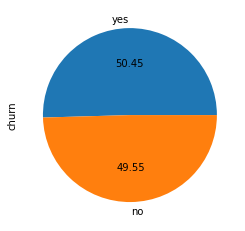

In [ ]:
calib_df.churn.value_counts().plot(kind='pie', autopct='%.2f')

perbandingan churn di holdout period

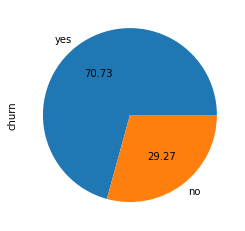

In [ ]:
holdout_df.churn.value_counts().plot(kind='pie', autopct='%.2f')

# EDA (Exploratory Data Analysis)

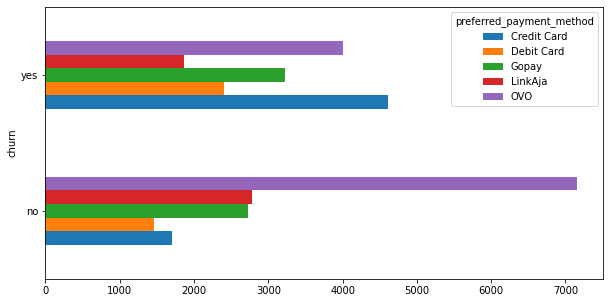

In [ ]:
calib_df.groupby('churn').preferred_payment_method.value_counts().unstack().plot.barh(figsize=(10,5))


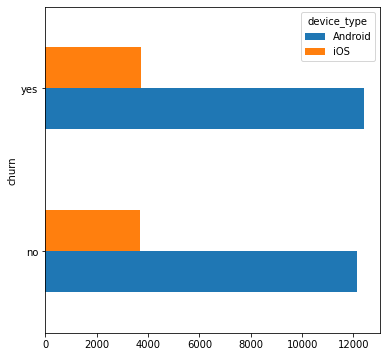

In [ ]:
calib_df.groupby('churn')['device_type'].value_counts().unstack().plot.barh(figsize=(6,6))

# Model

In [ ]:
!pip install xverse


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from xverse.ensemble import VotingSelector

## preproccessing

mengubah categorical menjadi float agar dapat diproses di model

In [ ]:
for x in calib_df.columns:
  if calib_df[x].dtype == 'object':
    calib_df[x] = calib_df[x].astype('category')
    calib_df[x] = calib_df[x].cat.codes

In [ ]:
calib_df

,customer_id,customer_days,number_order,total_amount,number_used_promo,ratio_success,first_to_last_buy_days,preferred_payment_method,ratio_booking,avg_value_per_order,days_since_last_trx,home_location,device_type,churn
0,3,1375.0,95.0,31879690.0,82,1.0,168.0,4,0.073684,236161.568421,1.0,6,0,0
1,8,472.0,12.0,8780977.0,0,1.0,152.0,0,0.250000,247403.083333,15.0,28,0,1
2,9,339.0,14.0,4185925.0,0,1.0,134.0,2,0.214286,246166.071429,2.0,6,0,1
3,11,86.0,14.0,2765462.0,14,1.0,0.0,4,0.071429,192025.000000,84.0,14,0,1
4,15,976.0,12.0,879840.0,12,1.0,0.0,0,0.083333,67200.000000,145.0,8,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32343,99988,1087.0,82.0,34409802.0,77,1.0,160.0,1,0.060976,135460.865854,5.0,20,1,1
32344,99989,422.0,5.0,1643406.0,0,1.0,120.0,4,0.400000,186922.600000,57.0,9,0,1
32346,99992,700.0,16.0,2521342.0,0,1.0,126.0,4,0.187500,150708.875000,5.0,16,0,1
32347,99995,653.0,227.0,74590049.0,32,1.0,168.0,4,0.066079,243020.528634,0.0,32,0,0


## selection feature untuk mencegah data leakage

In [ ]:
def get_information_values(data, target, bins=10, show_woe=False):
    
    #Empty Dataframe
    data_iv, data_woe = pd.DataFrame(), pd.DataFrame()

    #Extract Column Names
    cols = data.columns
    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d = d0.groupby("x", as_index=False).agg({"y": ["count", "sum"]})
        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Events']/d['% of Non-Events'])
        d['IV'] = d['WoE'] * (d['% of Events'] - d['% of Non-Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))
        temp = pd.DataFrame({"Variable" : [ivars], "IV" : [d['IV'].sum()]}, columns = ["Variable", "IV"])
        data_iv = pd.concat([data_iv, temp], axis=0)
        data_woe = pd.concat([data_woe, d], axis=0)

        #Show WOE Table
        if show_woe == True:
            print(d)

    return data_iv, data_woe

def cross_corr_mean(df_input, corr_coeff):
    corr_matrix = df_input.corr(method = 'spearman') 

    corr_mean = (np.abs(corr_matrix)).mean()

    features_drop_list = [] 
    features_index_drop_list = [] 
    corr_matrix = np.abs(corr_matrix)

    for i in range(corr_matrix.shape[0]):
        for j in range(i+1,corr_matrix.shape[0]):

            if corr_matrix.iloc[i,j]>corr_coeff and i not in features_index_drop_list and j not in features_index_drop_list:
            
                if corr_mean[corr_matrix.columns[i]] >= corr_mean[corr_matrix.columns[j]]:
                    features_drop_list.append(corr_matrix.columns[i])	
                    features_index_drop_list.append(i)	
                else:
                    features_drop_list.append(corr_matrix.columns[j])
                    features_index_drop_list.append(j)

    return features_drop_list

In [ ]:
iv_res, woe_res = get_information_values(calib_df, target='churn')

Information value of customer_id is 0.000666
Information value of customer_days is 0.053675
Information value of number_order is 3.010813
Information value of total_amount is 2.251841
Information value of number_used_promo is 1.333204
Information value of ratio_success is 0.108365
Information value of first_to_last_buy_days is 1.582194
Information value of preferred_payment_method is 0.351474
Information value of ratio_booking is 0.757055
Information value of avg_value_per_order is 0.383751
Information value of days_since_last_trx is 1.97132
Information value of home_location is 0.000393
Information value of device_type is 9e-05


In [ ]:
list_f_1 = iv_res[(iv_res.IV <= 0.5) & (iv_res.IV >= 0.02)].set_index('Variable')
list_f_1 = list_f_1.T.columns.to_list()
list_f_1

['customer_days',
 'ratio_success',
 'preferred_payment_method',
 'avg_value_per_order']

In [ ]:
df_filter_1 = calib_df[list_f_1]
df_filter_1

,customer_days,ratio_success,preferred_payment_method,avg_value_per_order
0,1375.0,1.0,4,236161.568421
1,472.0,1.0,0,247403.083333
2,339.0,1.0,2,246166.071429
3,86.0,1.0,4,192025.000000
4,976.0,1.0,0,67200.000000
...,...,...,...,...
32343,1087.0,1.0,1,135460.865854
32344,422.0,1.0,4,186922.600000
32346,700.0,1.0,4,150708.875000
32347,653.0,1.0,4,243020.528634


Melakukan drop pada attribut yang memiliki korelasi tinggi dengan label

In [ ]:
correlation = cross_corr_mean(df_filter_1, corr_coeff=0.9)
correlation

[]

In [ ]:
selected_df = df_filter_1.drop(columns=correlation)
selected_feature = selected_df.columns.to_list()
selected_df['churn'] = calib_df['churn']

In [ ]:
selected_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31961 entries, 0 to 32348
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   customer_days             31961 non-null  float64
 1   ratio_success             31961 non-null  float64
 2   preferred_payment_method  31961 non-null  int8   
 3   avg_value_per_order       31961 non-null  float64
 4   churn                     31961 non-null  int8   
dtypes: float64(3), int8(2)
memory usage: 1.0 MB


memisah feature dan label, dan juga membagi 70% untuk train dan 30% untuk testing

In [ ]:
X = selected_df.drop(columns={'churn'})
y = selected_df['churn']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

men-scale feature untuk model Logistic Regression dan Naive Bayes

In [ ]:
sc= StandardScaler()
X_train_sc = sc.fit_transform(X_train)
X_test_sc = sc.fit_transform(X_test)

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

logreg.fit(X_train_sc, y_train)
y_pred = logreg.predict(X_test_sc)

roc_auc = roc_auc_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)

logreg_report = {
    'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(logreg_report)))
print('classification_report : \n{}'.format(classification_report(y_test,y_pred)))

score : 
accuracy     0.630097
f1_score     0.622056
precision    0.643093
recall       0.602352
roc_auc      0.630398
gini         0.260796
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      4743
           1       0.64      0.60      0.62      4846

    accuracy                           0.63      9589
   macro avg       0.63      0.63      0.63      9589
weighted avg       0.63      0.63      0.63      9589



## Logistic Parameters Hyperparameter tuning

In [ ]:
params_logreg = {
    'penalty':['l1','l2'],
    'C': np.logspace(-4,4,20)
    }

gs_logreg = GridSearchCV(
    LogisticRegression(),
    param_grid = params_logreg,
     cv=10, 
    verbose=2)
gs_logreg.fit(X_train_sc,y_train)

In [ ]:
gs_logreg.best_params_

{'C': 0.012742749857031334, 'penalty': 'l2'}

In [ ]:
logreg_gs = LogisticRegression(**gs_logreg.best_params_)

logreg_gs.fit(X_train_sc, y_train)
y_pred = logreg_gs.predict(X_test_sc)

roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)

logreg_gs_report = {
    'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(logreg_gs_report)))
print('classification_report : \n{}'.format(classification_report(y_test,y_pred)))

score : 
accuracy     0.629993
f1_score     0.621990
precision    0.642952
recall       0.602352
roc_auc      0.630293
gini         0.260586
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.62      0.66      0.64      4743
           1       0.64      0.60      0.62      4846

    accuracy                           0.63      9589
   macro avg       0.63      0.63      0.63      9589
weighted avg       0.63      0.63      0.63      9589



## Naive Bayes Model

In [ ]:
from sklearn.naive_bayes import GaussianNB
nbmod = GaussianNB()

nbmod.fit(X_train_sc,y_train)
y_pred = nbmod.predict(X_test_sc)

roc_auc = roc_auc_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)

nbmod_report = {
    'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(nbmod_report)))
print('classification_report : \n{}'.format(classification_report(y_test,y_pred)))

score : 
accuracy     0.670143
f1_score     0.649140
precision    0.701847
recall       0.603797
roc_auc      0.670863
gini         0.341727
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.65      0.74      0.69      4743
           1       0.70      0.60      0.65      4846

    accuracy                           0.67      9589
   macro avg       0.67      0.67      0.67      9589
weighted avg       0.67      0.67      0.67      9589



## Naive Bayes Model Hyperparameter tuning

In [ ]:
params_NB = {'var_smoothing': np.logspace(0,-9, num=100)}

gs_nbmod = GridSearchCV(GaussianNB(),
    param_grid = params_NB,
     cv=10, 
    verbose=2)
gs_nbmod.fit(X_train_sc,y_train)

In [ ]:
gs_nbmod.best_params_

{'var_smoothing': 0.02848035868435802}

In [ ]:
nbmod_gs = GaussianNB(**gs_nbmod.best_params_)

nbmod_gs.fit(X_train_sc,y_train)
y_pred = nbmod_gs.predict(X_test_sc)

roc_auc = roc_auc_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)

nbmod_gs_report = {
    'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(nbmod_gs_report)))
print('classification_report : \n{}'.format(classification_report(y_test,y_pred)))

score : 
accuracy     0.669204
f1_score     0.646692
precision    0.702565
recall       0.599051
roc_auc      0.669966
gini         0.339932
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.64      0.74      0.69      4743
           1       0.70      0.60      0.65      4846

    accuracy                           0.67      9589
   macro avg       0.67      0.67      0.67      9589
weighted avg       0.67      0.67      0.67      9589



## XGBoost

In [ ]:
from xgboost import XGBClassifier
xgbmod = XGBClassifier()

xgbmod.fit(X_train,y_train)
y_pred = xgbmod.predict(X_test)

roc_auc = roc_auc_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)

xgb_report = {
    'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(xgb_report)))
print('classification_report : \n{}'.format(classification_report(y_test,y_pred)))

score : 
accuracy     0.689853
f1_score     0.692514
precision    0.693949
recall       0.691085
roc_auc      0.689840
gini         0.379679
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      4743
           1       0.69      0.69      0.69      4846

    accuracy                           0.69      9589
   macro avg       0.69      0.69      0.69      9589
weighted avg       0.69      0.69      0.69      9589



## XGBoost hyperparameter tuning

In [ ]:
xg_param_grid ={
    'max_depth':range(2, 9, 1),
    'n_estimators':range(50, 200, 50),
    'learning_rate':[0.1, 0.01]
}

In [ ]:
gs_xgb = GridSearchCV(XGBClassifier(), xg_param_grid, cv=3, verbose=2)
gs_xgb.fit(X_train,y_train)

In [ ]:
gs_xgb.best_params_

{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100}

In [ ]:
xgbmod_gs = XGBClassifier(**gs_xgb.best_params_)

xgbmod_gs.fit(X_train,y_train)
y_pred = xgbmod_gs.predict(X_test)

roc_auc = roc_auc_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)

xg_gs_report = {
    'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(xg_gs_report)))
print('classification_report : \n{}'.format(classification_report(y_test,y_pred)))

score : 
accuracy     0.689853
f1_score     0.692514
precision    0.693949
recall       0.691085
roc_auc      0.689840
gini         0.379679
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.69      0.69      0.69      4743
           1       0.69      0.69      0.69      4846

    accuracy                           0.69      9589
   macro avg       0.69      0.69      0.69      9589
weighted avg       0.69      0.69      0.69      9589



## Random Forest Classifier model

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rfmod = RandomForestClassifier()

rfmod.fit(X_train,y_train)
y_pred = rfmod.predict(X_test)

roc_auc = roc_auc_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)

rfmod_report = {
    'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(rfmod_report)))
print('classification_report : \n{}'.format(classification_report(y_test,y_pred)))

score : 
accuracy     0.649807
f1_score     0.652740
precision    0.654229
recall       0.651259
roc_auc      0.649791
gini         0.299583
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.65      0.65      0.65      4743
           1       0.65      0.65      0.65      4846

    accuracy                           0.65      9589
   macro avg       0.65      0.65      0.65      9589
weighted avg       0.65      0.65      0.65      9589



## Random Forest Classifier hyperparameter tuning

In [ ]:
rf_param_grid = {
    'max_depth': [7, 8, 9],
    'max_features': ['log2', 'sqrt'],
    'n_estimators': [100, 150, 200],
    'criterion': ['gini', 'entropy']
}

In [ ]:
gs_rfmod = GridSearchCV(RandomForestClassifier(), rf_param_grid, cv=3, verbose=2)
gs_rfmod.fit(X_train,y_train)

In [ ]:
gs_rfmod.best_params_

{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 150}

In [ ]:
rfmod_gs = RandomForestClassifier(**gs_rfmod.best_params_)

rfmod_gs.fit(X_train,y_train)
y_pred = rfmod_gs.predict(X_test)

roc_auc = roc_auc_score(y_test,y_pred)
f1 = f1_score(y_test,y_pred)
recall = recall_score(y_test,y_pred)
acc = accuracy_score(y_test,y_pred)
prec = precision_score(y_test,y_pred)

rfmod_gs_report = {
    'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(rfmod_gs_report)))
print('classification_report : \n{}'.format(classification_report(y_test,y_pred)))

score : 
accuracy     0.686203
f1_score     0.689442
precision    0.689655
recall       0.689228
roc_auc      0.686170
gini         0.372340
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      4743
           1       0.69      0.69      0.69      4846

    accuracy                           0.69      9589
   macro avg       0.69      0.69      0.69      9589
weighted avg       0.69      0.69      0.69      9589



## perbandingan model di calibration

In [ ]:
acc_calibration = {
    'Logistic Regression':[logreg_report['accuracy'], logreg_report['f1_score'], logreg_report['precision'], logreg_report['recall'], logreg_report['roc_auc'], logreg_report['gini']],
    'Logistic Regression w/ Grid Search CV':[logreg_gs_report['accuracy'], logreg_gs_report['f1_score'], logreg_gs_report['precision'], logreg_gs_report['recall'], logreg_gs_report['roc_auc'], logreg_gs_report['gini']],
    'Naive Bayes':[nbmod_report['accuracy'], nbmod_report['f1_score'], nbmod_report['precision'], nbmod_report['recall'], nbmod_report['roc_auc'], nbmod_report['gini']],
    'Naive Bayes w/ Grid Search CV':[nbmod_gs_report['accuracy'], nbmod_gs_report['f1_score'], nbmod_gs_report['precision'], nbmod_gs_report['recall'], nbmod_gs_report['roc_auc'], nbmod_gs_report['gini']],
    'XGBoost':[xgb_report['accuracy'], xgb_report['f1_score'], xgb_report['precision'], xgb_report['recall'], xgb_report['roc_auc'], xgb_report['gini']],
    'XGBoost w/ Grid Search':[xg_gs_report['accuracy'], xg_gs_report['f1_score'], xg_gs_report['precision'], xg_gs_report['recall'], xg_gs_report['roc_auc'], xg_gs_report['gini']],
    'Random Forest Classifier':[rfmod_report['accuracy'], rfmod_report['f1_score'], rfmod_report['precision'], rfmod_report['recall'], rfmod_report['roc_auc'], rfmod_report['gini']],
    'Random Forest Classifier w/ Grid Search CV':[rfmod_gs_report['accuracy'], rfmod_gs_report['f1_score'], rfmod_gs_report['precision'], rfmod_gs_report['recall'], rfmod_gs_report['roc_auc'], rfmod_gs_report['gini']]
}

acc_calibration = pd.DataFrame(acc_calibration).T
acc_calibration = acc_calibration.rename(columns={0:'accuracy', 1:'f1-score', 2:'precision', 3:'recall', 4:'roc-auc',5:'gini'})
acc_calibration = acc_calibration.sort_values(by='accuracy',ascending=False)
acc_calibration

,accuracy,f1-score,precision,recall,roc-auc,gini
XGBoost,0.689853,0.692514,0.693949,0.691085,0.689840,0.379679
XGBoost w/ Grid Search,0.689853,0.692514,0.693949,0.691085,0.689840,0.379679
Random Forest Classifier w/ Grid Search CV,0.686203,0.689442,0.689655,0.689228,0.686170,0.372340
Naive Bayes,0.670143,0.649140,0.701847,0.603797,0.670863,0.341727
Naive Bayes w/ Grid Search CV,0.669204,0.646692,0.702565,0.599051,0.669966,0.339932
Random Forest Classifier,0.649807,0.652740,0.654229,0.651259,0.649791,0.299583
Logistic Regression,0.630097,0.622056,0.643093,0.602352,0.630398,0.260796
Logistic Regression w/ Grid Search CV,0.629993,0.621990,0.642952,0.602352,0.630293,0.260586


# Memprediksi data holdout

In [ ]:
for x in holdout_df.columns:
  if holdout_df[x].dtype == 'object':
    holdout_df[x] = holdout_df[x].astype('category')
    holdout_df[x] = holdout_df[x].cat.codes

In [ ]:
X = holdout_df[selected_feature]
y = holdout_df['churn']

sc = StandardScaler()
X_holdout_sc = sc.fit_transform(X)


## prediksi dari setiap model

In [ ]:
y_pred = logreg.predict(X_holdout_sc)

roc_auc = roc_auc_score(y, y_pred)
f1 = f1_score(y, y_pred)
recall = recall_score(y, y_pred)
acc = accuracy_score(y, y_pred)
prec = precision_score(y ,y_pred)

logreg_report_holdout = {
    'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(logreg_report_holdout)))
print('classification_report : \n{}'.format(classification_report(y, y_pred)))

score : 
accuracy     0.616604
f1_score     0.674592
precision    0.843856
recall       0.561887
roc_auc      0.655345
gini         0.310691
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.41      0.75      0.53      9196
           1       0.84      0.56      0.67     22218

    accuracy                           0.62     31414
   macro avg       0.63      0.66      0.60     31414
weighted avg       0.72      0.62      0.63     31414



In [ ]:
y_pred = logreg_gs.predict(X_holdout_sc)

roc_auc = roc_auc_score(y, y_pred)
f1 = f1_score(y, y_pred)
recall = recall_score(y, y_pred)
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)

logreg_gs_report_holdout = {
    'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(logreg_gs_report_holdout)))
print('classification_report : \n{}'.format(classification_report(y, y_pred)))

score : 
accuracy     0.616604
f1_score     0.674610
precision    0.843809
recall       0.561932
roc_auc      0.655313
gini         0.310627
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.41      0.75      0.53      9196
           1       0.84      0.56      0.67     22218

    accuracy                           0.62     31414
   macro avg       0.63      0.66      0.60     31414
weighted avg       0.72      0.62      0.63     31414



In [ ]:
y_pred = nbmod.predict(X_holdout_sc)

roc_auc = roc_auc_score(y,y_pred)
f1 = f1_score(y,y_pred)
recall = recall_score(y,y_pred)
acc = accuracy_score(y,y_pred)
prec = precision_score(y,y_pred)

nbmod_report_holdout = {
    'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(nbmod_report_holdout)))
print('classification_report : \n{}'.format(classification_report(y,y_pred)))

score : 
accuracy     0.619692
f1_score     0.667112
precision    0.875649
recall       0.538797
roc_auc      0.676967
gini         0.353934
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.42      0.82      0.56      9196
           1       0.88      0.54      0.67     22218

    accuracy                           0.62     31414
   macro avg       0.65      0.68      0.61     31414
weighted avg       0.74      0.62      0.63     31414



In [ ]:
y_pred = nbmod_gs.predict(X_holdout_sc)

roc_auc = roc_auc_score(y,y_pred)
f1 = f1_score(y,y_pred)
recall = recall_score(y,y_pred)
acc = accuracy_score(y,y_pred)
prec = precision_score(y,y_pred)

nbmod_gs_report_holdout = {
    'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(nbmod_gs_report_holdout)))
print('classification_report : \n{}'.format(classification_report(y,y_pred)))

score : 
accuracy     0.617400
f1_score     0.663701
precision    0.877154
recall       0.533801
roc_auc      0.676590
gini         0.353179
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.42      0.82      0.56      9196
           1       0.88      0.53      0.66     22218

    accuracy                           0.62     31414
   macro avg       0.65      0.68      0.61     31414
weighted avg       0.74      0.62      0.63     31414



In [ ]:
y_pred = xgbmod.predict(X)

roc_auc = roc_auc_score(y, y_pred)
f1 = f1_score(y, y_pred)
recall = recall_score(y, y_pred)
acc = accuracy_score(y, y_pred)
prec = precision_score(y, y_pred)

xgb_report_holdout = {
    'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(xgb_report_holdout)))
print('classification_report : \n{}'.format(classification_report(y,y_pred)))

score : 
accuracy     0.676036
f1_score     0.733118
precision    0.878291
recall       0.629130
roc_auc      0.709247
gini         0.418494
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.47      0.79      0.59      9196
           1       0.88      0.63      0.73     22218

    accuracy                           0.68     31414
   macro avg       0.67      0.71      0.66     31414
weighted avg       0.76      0.68      0.69     31414



In [ ]:
y_pred = xgbmod_gs.predict(X)

roc_auc = roc_auc_score(y,y_pred)
f1 = f1_score(y,y_pred)
recall = recall_score(y,y_pred)
acc = accuracy_score(y,y_pred)
prec = precision_score(y,y_pred)

xg_gs_report_holdout = {
   'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(xg_gs_report_holdout)))
print('classification_report : \n{}'.format(classification_report(y,y_pred)))

score : 
accuracy     0.676036
f1_score     0.733118
precision    0.878291
recall       0.629130
roc_auc      0.709247
gini         0.418494
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.47      0.79      0.59      9196
           1       0.88      0.63      0.73     22218

    accuracy                           0.68     31414
   macro avg       0.67      0.71      0.66     31414
weighted avg       0.76      0.68      0.69     31414



In [ ]:
y_pred = rfmod.predict(X)

roc_auc = roc_auc_score(y,y_pred)
f1 = f1_score(y,y_pred)
recall = recall_score(y,y_pred)
acc = accuracy_score(y,y_pred)
prec = precision_score(y,y_pred)

rfmod_report_holdout = {
    'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(rfmod_report_holdout)))
print('classification_report : \n{}'.format(classification_report(y,y_pred)))

score : 
accuracy     0.661616
f1_score     0.726932
precision    0.846738
recall       0.636826
roc_auc      0.679168
gini         0.358335
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.45      0.72      0.56      9196
           1       0.85      0.64      0.73     22218

    accuracy                           0.66     31414
   macro avg       0.65      0.68      0.64     31414
weighted avg       0.73      0.66      0.68     31414



In [ ]:
y_pred = rfmod_gs.predict(X)

roc_auc = roc_auc_score(y,y_pred)
f1 = f1_score(y,y_pred)
recall = recall_score(y,y_pred)
acc = accuracy_score(y,y_pred)
prec = precision_score(y,y_pred)

rfmod_gs_report_holdout = {
    'accuracy': acc, 
    'f1_score': f1, 
    'precision':prec, 
    'recall': recall, 
    'roc_auc': roc_auc,
    'gini' : 2 * roc_auc - 1
}

print('score : \n{}\n'.format(pd.Series(rfmod_gs_report_holdout)))
print('classification_report : \n{}'.format(classification_report(y,y_pred)))

score : 
accuracy     0.677437
f1_score     0.734119
precision    0.880199
recall       0.629625
roc_auc      0.711289
gini         0.422578
dtype: float64

classification_report : 
              precision    recall  f1-score   support

           0       0.47      0.79      0.59      9196
           1       0.88      0.63      0.73     22218

    accuracy                           0.68     31414
   macro avg       0.68      0.71      0.66     31414
weighted avg       0.76      0.68      0.69     31414



## perbandingan setiap model di holdout

In [ ]:
acc_holdout = {
    'Logistic Regression': [logreg_report_holdout['accuracy'], logreg_report_holdout['f1_score'], logreg_report_holdout['precision'], logreg_report_holdout['recall'], logreg_report_holdout['roc_auc'], logreg_report_holdout['gini']],
    'Logistic Regression w/ Grid Search CV': [logreg_gs_report_holdout['accuracy'], logreg_gs_report_holdout['f1_score'], logreg_gs_report_holdout['precision'], logreg_gs_report_holdout['recall'], logreg_gs_report_holdout['roc_auc'], logreg_gs_report_holdout['gini']],
    'Naive Bayes': [nbmod_report_holdout['accuracy'], nbmod_report_holdout['f1_score'], nbmod_report_holdout['precision'], nbmod_report_holdout['recall'], nbmod_report_holdout['roc_auc'], nbmod_report_holdout['gini']],
    'Naive Bayes w/ Grid Search CV': [nbmod_gs_report_holdout['accuracy'], nbmod_gs_report_holdout['f1_score'], nbmod_gs_report_holdout['precision'], nbmod_gs_report_holdout['recall'], nbmod_gs_report_holdout['roc_auc'], nbmod_gs_report_holdout['gini']],
    'XGBoost':[xgb_report_holdout['accuracy'], xgb_report_holdout['f1_score'], xgb_report_holdout['precision'], xgb_report_holdout['recall'], xgb_report_holdout['roc_auc'], xgb_report_holdout['gini']],
    'XGBoost w/ Grid Search':[xg_gs_report_holdout['accuracy'], xg_gs_report_holdout['f1_score'], xg_gs_report_holdout['precision'], xg_gs_report_holdout['recall'], xg_gs_report_holdout['roc_auc'], xg_gs_report_holdout['gini']],
    'Random Forest Classifier':[rfmod_report_holdout['accuracy'], rfmod_report_holdout['f1_score'], rfmod_report_holdout['precision'], rfmod_report_holdout['recall'], rfmod_report_holdout['roc_auc'], rfmod_report_holdout['gini']],
    'Random Forest Classifier w/ Grid Search CV':[rfmod_gs_report_holdout['accuracy'], rfmod_gs_report_holdout['f1_score'], rfmod_gs_report_holdout['precision'], rfmod_gs_report_holdout['recall'], rfmod_gs_report_holdout['roc_auc'], rfmod_gs_report_holdout['gini']]
}

acc_holdout = pd.DataFrame(acc_holdout).T
acc_holdout = acc_holdout.rename(columns={0:'accuracy', 1:'f1-score', 2:'precision', 3:'recall', 4:'roc-auc',5:'gini'})
acc_holdout = acc_holdout.sort_values(by='accuracy',ascending=False)
acc_holdout

,accuracy,f1-score,precision,recall,roc-auc,gini
Random Forest Classifier w/ Grid Search CV,0.677437,0.734119,0.880199,0.629625,0.711289,0.422578
XGBoost,0.676036,0.733118,0.878291,0.629130,0.709247,0.418494
XGBoost w/ Grid Search,0.676036,0.733118,0.878291,0.629130,0.709247,0.418494
Random Forest Classifier,0.661616,0.726932,0.846738,0.636826,0.679168,0.358335
Naive Bayes,0.619692,0.667112,0.875649,0.538797,0.676967,0.353934
Naive Bayes w/ Grid Search CV,0.617400,0.663701,0.877154,0.533801,0.676590,0.353179
Logistic Regression,0.616604,0.674592,0.843856,0.561887,0.655345,0.310691
Logistic Regression w/ Grid Search CV,0.616604,0.674610,0.843809,0.561932,0.655313,0.310627


# feature Importance

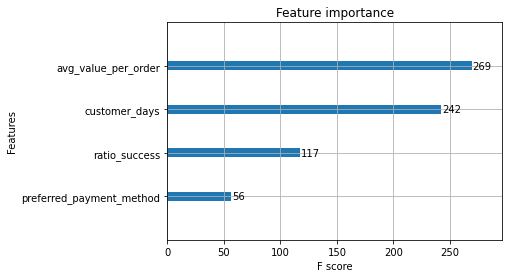

<Figure size 1152x864 with 0 Axes>

In [ ]:
import xgboost

xgboost.plot_importance(xgbmod)
plt.figure(figsize = (16, 12))
plt.show()

<Figure size 1152x864 with 0 Axes>

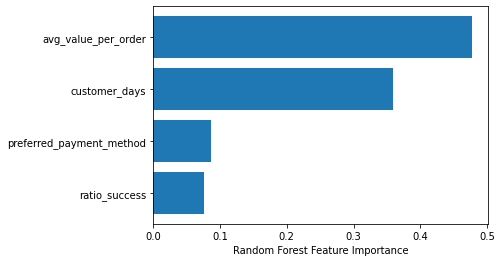

<Figure size 1152x864 with 0 Axes>

In [ ]:
sorted_idx = rfmod.feature_importances_.argsort()
plt.barh(X_train.columns[sorted_idx], rfmod.feature_importances_[sorted_idx])
plt.xlabel("Random Forest Feature Importance")
plt.figure(figsize = (16, 12))

# Kesimpulan

## Best Model:
dari model prediksi klasifikasi di data holdout terlihat model yang paling baik adalah model Random Forest.


## Bussiness Problem:
berdasarkan Feature Importance pada model XGBoost dan Random Forest Classifier, feature yang paling berpengaruh adalah rata-rata harga barang per order. Oleh karena itu ada beberapa saran yang kami berikan, diantaranya:
* memberikan diskon harga barang supaya lebih terjangkau
* customer yang telah lama ada lebih dari 3 bulan diberikan promo daripada akun yng kurang dari 3 bulan